<a href="https://colab.research.google.com/github/yermaka-a/collab-exes/blob/pytorch_collab_exes/03_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2.8.0+cu126


In [2]:
# 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.
# hold-out
# k-fold
# early stopping
# augmentation

In [3]:
import torchvision
DATASET_PATH = './data'
train_data = torchvision.datasets.MNIST(
    root=DATASET_PATH,
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)
test_data = torchvision.datasets.MNIST(
    root=DATASET_PATH,
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)
len(train_data), len(test_data)

(60000, 10000)

In [4]:
class_names = train_data.classes

In [5]:
class_to_idx = train_data.class_to_idx

In [6]:
train_data.targets
image, label = train_data[0]

image.shape

torch.Size([1, 28, 28])

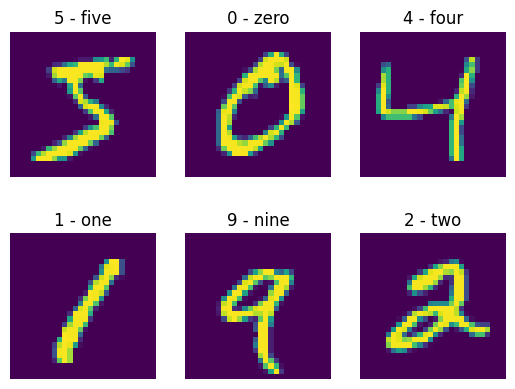

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3)
ord = 0
for j in range(2):
  for i in range(3):
    image, label = train_data[ord]
    ax[j, i].imshow(image.squeeze())
    ax[j, i].axis('off')
    ax[j, i].set_title(class_names[label])
    ord+=1


In [8]:
BATCH_SIZE = 32
train_dataloader = torch.utils.data.DataLoader(
    batch_size=BATCH_SIZE,
    dataset=train_data,
    shuffle=True,
)

test_dataloader = torch.utils.data.DataLoader(
    batch_size=BATCH_SIZE,
    dataset=test_data,
    shuffle=False,
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7dca22ac6540>,
 <torch.utils.data.dataloader.DataLoader at 0x7dca22c9f950>)

In [9]:
import torch.nn as nn
class MNISTModelV2(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=1,
            padding=1,
            stride=1
            ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=1,
            padding=1,
            stride=1
            ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
        )
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=1,
            padding=1,
            stride=1
            ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1,
            stride=1
            ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
        )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*9*9,
            out_features=output_shape
        )
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    return self.classifier(x)

In [10]:
torch.manual_seed(42)
model_2 = MNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
    ).to(device)

In [11]:
torch_img_tensor = torch.randn(size=(1,28,28)).to(device)
torch_img_tensor.shape

torch.Size([1, 28, 28])

In [12]:
y_pred = model_2(torch_img_tensor.unsqueeze(0))

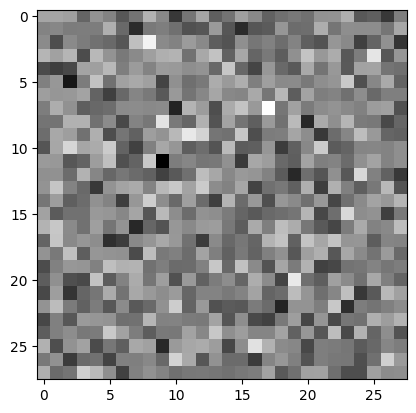

In [13]:
y_pred.argmax()
class_names[y_pred.argmax()]
plt.imshow(torch_img_tensor.cpu().squeeze(0), cmap='gray')

In [14]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_2.parameters(),
    lr=0.1
)

In [15]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy,
    device: torch.device = device
    ):
    """
    performs training step with model trying to learn on data_loader
    """
    train_loss, train_acc = 0, 0
    model.train()

    for batch_idx, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc += accuracy(y_true=y,
                            y_pred=y_pred.argmax(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f}%",end='\n')

def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy,
    device: torch.device = device
):
  """ Performs a testing loop step with model going over data_loader
  """
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for batch_idx, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += accuracy(y_true=y,
                           y_pred=y_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}%", end='\n')

In [16]:
import tqdm

In [17]:
def print_train_time(start, end, device):
  print(f"Train time on :{device} | Time: {(end - start):.3f}")

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as timer
train_timer_start_model_2 = timer()

# train and test model
epochs = 5

for epoch in tqdm.tqdm(range(epochs)):
  print(f"epoch: {epoch}---------------")
  train_step(
      model=model_2,
      accuracy=accuracy_fn,
      data_loader=train_dataloader,
      device=device,
      loss_fn=loss_fn,
      optimizer=optimizer
  )
  test_step(
      model=model_2,
      accuracy=accuracy_fn,
      data_loader=test_dataloader,
      device=device,
      loss_fn=loss_fn
  )
  print('\n')

train_timer_end_model_2 = timer()

print_train_time(train_timer_start_model_2, train_timer_end_model_2, device)


  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0---------------
train_loss: 0.4223 | train_acc: 85.5067%


 20%|██        | 1/5 [00:20<01:20, 20.25s/it]

test_loss: 0.0970 | test_acc: 97.3043%


epoch: 1---------------
train_loss: 0.0997 | train_acc: 96.9267%


 40%|████      | 2/5 [00:31<00:45, 15.21s/it]

test_loss: 0.0699 | test_acc: 97.8335%


epoch: 2---------------
train_loss: 0.0830 | train_acc: 97.4867%


 60%|██████    | 3/5 [00:43<00:27, 13.60s/it]

test_loss: 0.0711 | test_acc: 97.7236%


epoch: 3---------------
train_loss: 0.0756 | train_acc: 97.6633%


 80%|████████  | 4/5 [00:55<00:12, 12.91s/it]

test_loss: 0.0771 | test_acc: 97.5240%


epoch: 4---------------
train_loss: 0.0685 | train_acc: 97.8550%


100%|██████████| 5/5 [01:09<00:00, 13.90s/it]

test_loss: 0.0616 | test_acc: 97.8435%


Train time on :cuda | Time: 69.485


In [19]:
!nvidia-smi

Wed Sep  3 12:06:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P0             28W /   70W |     184MiB /  15360MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

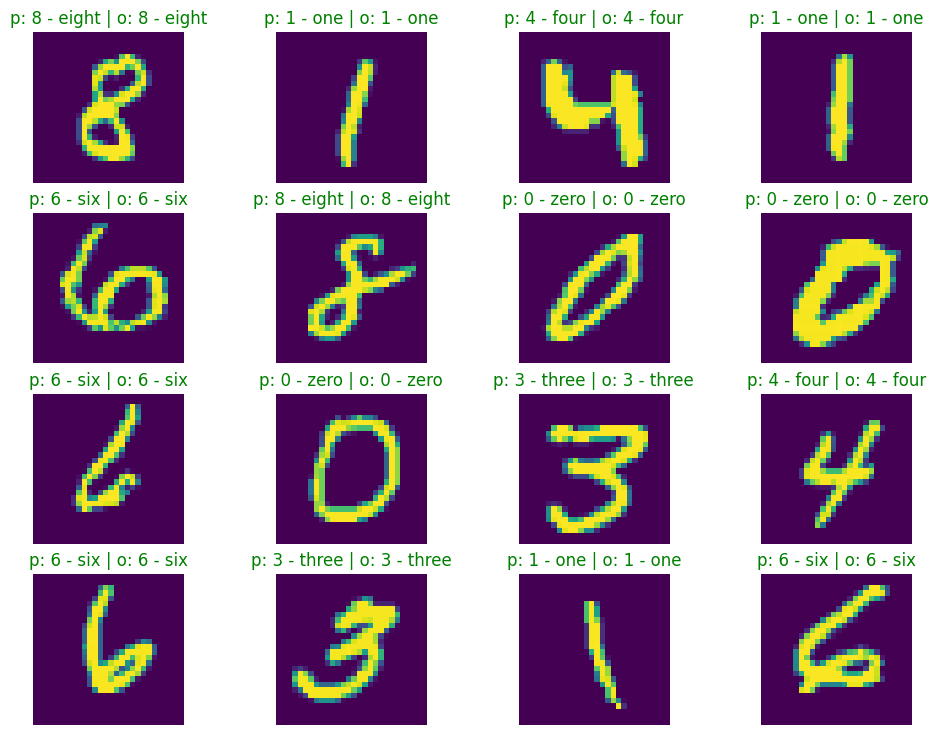

In [20]:
model_2.eval()
with torch.inference_mode():
  fig = plt.figure(figsize=(12,9))
  rows, cols = 4, 4
  for i  in range(1, rows * cols + 1):
      idx = torch.randint(0, len(test_data), size=[1]).item()
      image, label = test_data[idx]
      y_pred = model_2(image.to(device).unsqueeze(0))
      fig.add_subplot(rows, cols, i)
      plt.imshow(image.squeeze(0))
      plt.axis(False)
      pred_name = class_names[y_pred.argmax()]
      orig_name = class_names[label]
      if pred_name == orig_name:
        plt.title(f"p: {pred_name} | o: {orig_name}", c='g')
      else:
        plt.title(f"p: {pred_name} | o: {orig_name}", c='r')

In [21]:
!pip install torchmetrics & pip install mlxtend

In [22]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making preds..."):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

  y_pred_tensor = torch.cat(y_preds)
  y_pred_tensor[:10]

Making preds...:   0%|          | 0/313 [00:00<?, ?it/s]

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

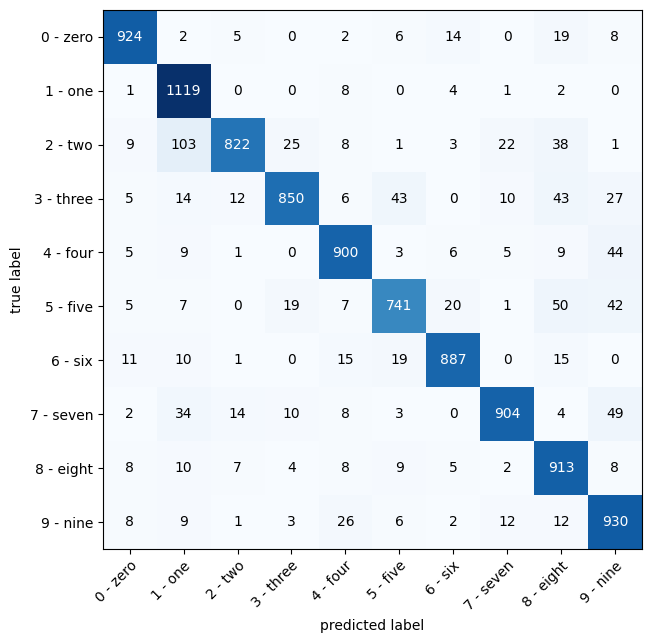

In [23]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(
    task='multiclass',
    num_classes=len(class_names),
)
confmat_tensor = confmat(
    preds=y_pred_tensor,
    target = test_data.targets
)
plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

In [24]:
rand_t = torch.randn(size=(1, 3, 64, 64))
conv2d = nn.Conv2d(3, 3, 3)
conv2d(rand_t).shape

torch.Size([1, 3, 62, 62])

(Text(0.5, 1.0, '7 - seven'),)

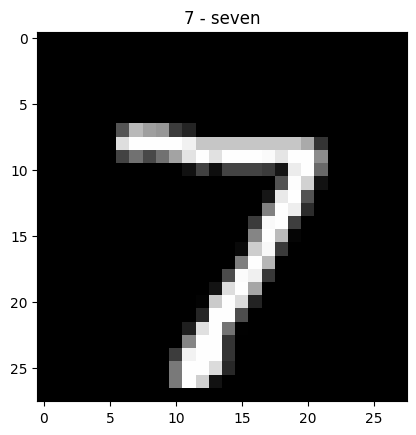

In [25]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
image, label = test_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label]),

In [26]:
from torchvision.datasets import FashionMNIST

train_data = FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [61]:
torch.manual_seed(42)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True,

)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=False,
)

In [80]:
import torch.nn as nn
class FashionMNISTV2(nn.Module):
  def __init__(self, in_shape, hidden_units, out_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=in_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
          nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2
        )
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2
        )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units * 7 * 7,
            out_features=out_shape
        )
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)

    return self.classifier(x)

Text(0.5, 1.0, '4 - four')

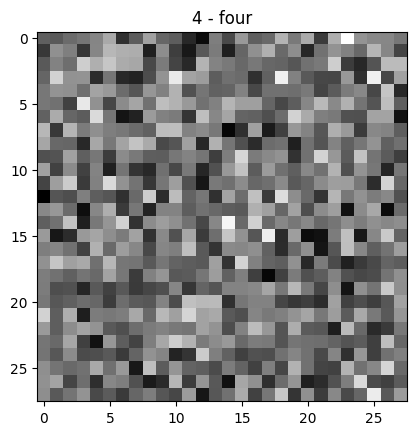

In [81]:
model_3 = FashionMNISTV2(1, 10, len(class_names)).to(device)
rand_t = torch.randn(size=(1, 28, 28)).to(device).unsqueeze(dim=1)
y_pred = model_3(rand_t)
plt.imshow(rand_t.cpu().squeeze(), cmap='gray')
plt.title(class_names[y_pred.argmax()])

In [86]:
optimizer = torch.optim.SGD(
    params=model_3.parameters(),
    lr=0.1
)

In [87]:
epochs = 5
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch} ------------\n')
  train_step(
      model=model_3,
      data_loader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy=accuracy_fn,
      device=device
  )
  test_step(
      model=model_3,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      accuracy=accuracy_fn,
      device=device
  )
  print('\n')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 ------------

train_loss: 0.2071 | train_acc: 92.5356%
test_loss: 0.2591 | test_acc: 90.7743%


Epoch: 1 ------------

train_loss: 0.2053 | train_acc: 92.6073%
test_loss: 0.2604 | test_acc: 90.9335%


Epoch: 2 ------------

train_loss: 0.2042 | train_acc: 92.6572%
test_loss: 0.2658 | test_acc: 90.7245%


Epoch: 3 ------------

train_loss: 0.2036 | train_acc: 92.6989%
test_loss: 0.2581 | test_acc: 90.9236%


Epoch: 4 ------------

train_loss: 0.2024 | train_acc: 92.7972%
test_loss: 0.2604 | test_acc: 91.0032%




In [116]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
from tqdm.auto import tqdm
y_preds = []
model_3.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="making preds..."):
    X, y = X.to(device), y.to(device)
    y_logit = model_3(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())
  y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

making preds...:   0%|          | 0/157 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

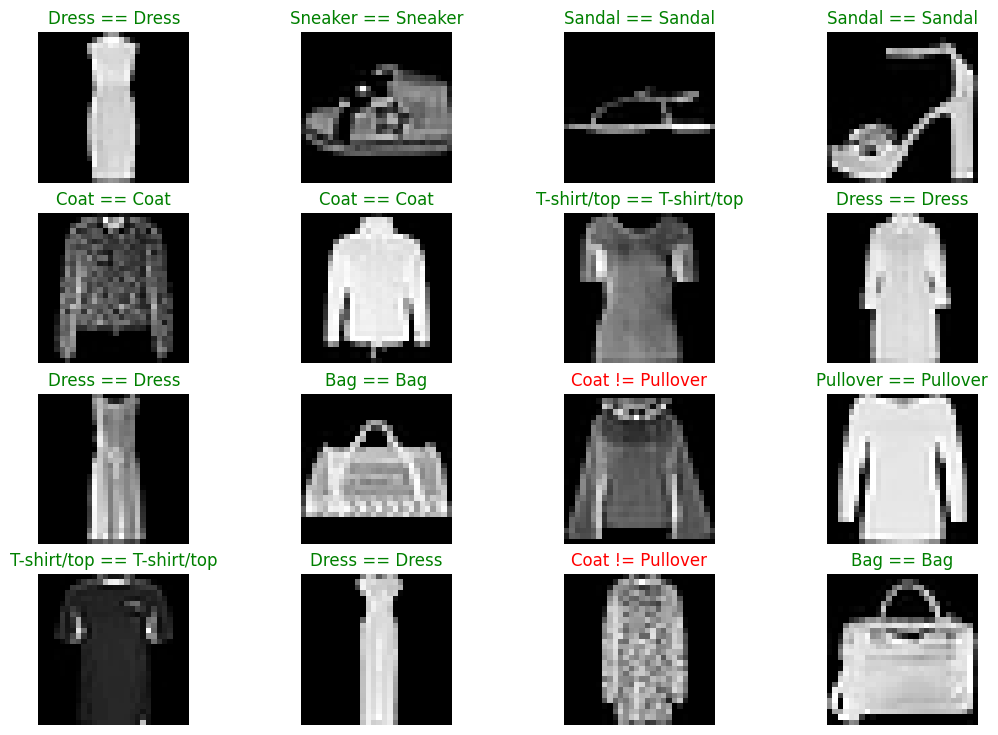

In [121]:
model_3.eval()
with torch.inference_mode():
  rows, cols = 4, 4
  fig = plt.figure(figsize=(13, 9))
  for i in range(1, rows * cols + 1):
    rand_idx = torch.randint(0, len(test_data), size=[1]).item()
    image, label = test_data[rand_idx]
    image = image.to(device)
    y_pred = model_3(image.unsqueeze(0))
    pred = y_pred.argmax()
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.axis(False)
    if class_names[label] == class_names[pred]:
      plt.title(f'{class_names[pred]} == {class_names[label]}', c='g')
    else:
      plt.title(f'{class_names[pred]} != {class_names[label]}', c='r')


(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

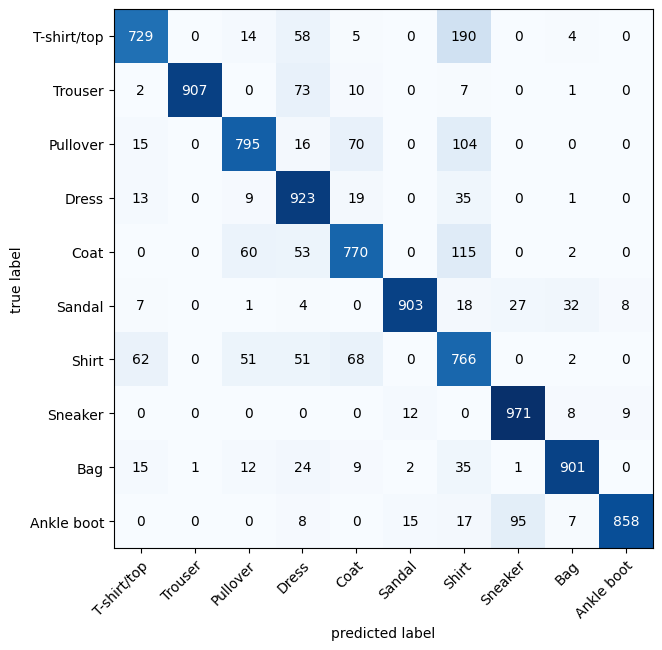

In [130]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(
    task='multiclass',
    num_classes=len(class_names)
)

confmat_tensor = confmat(
    preds=y_pred_tensor,
    target=test_data.targets
)

plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
    )